In [ ]:
#Code taken and modified from https://github.com/SullyChen/Molecular-Solubility-with-PyTorch-Geometric/blob/main/Molecular%20Solubility.ipynb

In [ ]:
!pip install pysmiles
!pip install torch_geometric
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
with open('/content/drive/MyDrive/SolPred/curated-solubility-dataset.csv', 'r') as f:
  df = pd.read_csv(f) #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file
X_data = np.stack((np.asarray(df['MolWt']),np.asarray(df['MolLogP']),np.asarray(df['MolMR']),np.asarray(df['HeavyAtomCount']),np.asarray(df['NumHAcceptors']),np.asarray(df['NumHDonors']),np.asarray(df['NumHeteroatoms']),np.asarray(df['NumRotatableBonds']),np.asarray(df['NumValenceElectrons']),np.asarray(df['NumAromaticRings']),np.asarray(df['NumSaturatedRings']),np.asarray(df['NumAliphaticRings']),np.asarray(df['RingCount']),np.asarray(df['TPSA']),np.asarray(df['LabuteASA']),np.asarray(df['BalabanJ']),np.asarray(df['BertzCT'])),axis=0).T
print(X_data.shape)

X_data_mean = np.mean(X_data,0)
print(X_data_mean.shape)

X_data_std = np.std(X_data,0)

X_data = (X_data-X_data_mean)/X_data_std

elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#convert solubility value to one-hot class vector
def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(9982, 17)
(17,)


100%|██████████| 9982/9982 [00:25<00:00, 395.71it/s]


In [ ]:
#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.long) #convert edge index into torch tensor
    y = torch.tensor([val_to_class(Y[i])], dtype=torch.float) #change shape of label and convert to tensor
    data.append((Data(x=x,edge_index=edges, y=y),torch.from_numpy(X_data[i].astype(np.float32)))) #add the Data object to the list of data
random.shuffle(data)
train = data[:int(len(data)*0.8)] #train set
test = data[int(len(data)*0.8):] #val set

100%|██████████| 9947/9947 [00:01<00:00, 6015.15it/s]


In [ ]:
#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(78, 86)
        self.conv2 = GCNConv(86, 64)
        self.conv3 = GCNConv(64, 32)

        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 3)




    def forward(self, gdata, ldata):
        x, edge_index= gdata.x, gdata.edge_index
        #print(x.shape)
        #print(ldata.repeat(len(x),1).shape)
        x = torch.cat((x,ldata.repeat(len(x),1)),1)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x,edge_index)
        x = F.relu(x)



        x = torch.sum(x, dim=0)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)



        return x

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(200): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d[0].to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data, d[1]) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

100%|██████████| 7957/7957 [01:08<00:00, 116.42it/s]


Epoch: 000, Average loss: 0.80492, Accuracy: 0.66709


100%|██████████| 7957/7957 [00:48<00:00, 164.65it/s]


Epoch: 001, Average loss: 0.72433, Accuracy: 0.70378


100%|██████████| 7957/7957 [00:52<00:00, 150.74it/s]


Epoch: 002, Average loss: 0.69800, Accuracy: 0.71472


100%|██████████| 7957/7957 [00:52<00:00, 151.30it/s]


Epoch: 003, Average loss: 0.67943, Accuracy: 0.72427


100%|██████████| 7957/7957 [00:50<00:00, 158.97it/s]


Epoch: 004, Average loss: 0.65125, Accuracy: 0.73143


100%|██████████| 7957/7957 [00:51<00:00, 154.63it/s]


Epoch: 005, Average loss: 0.64918, Accuracy: 0.73859


100%|██████████| 7957/7957 [00:52<00:00, 150.88it/s]


Epoch: 006, Average loss: 0.62419, Accuracy: 0.73633


100%|██████████| 7957/7957 [00:54<00:00, 146.78it/s]


Epoch: 007, Average loss: 0.62526, Accuracy: 0.74224


100%|██████████| 7957/7957 [00:55<00:00, 143.30it/s]


Epoch: 008, Average loss: 0.62047, Accuracy: 0.74073


100%|██████████| 7957/7957 [00:50<00:00, 156.55it/s]


Epoch: 009, Average loss: 0.62873, Accuracy: 0.74425


100%|██████████| 7957/7957 [00:51<00:00, 154.50it/s]


Epoch: 010, Average loss: 0.61434, Accuracy: 0.74802


100%|██████████| 7957/7957 [00:50<00:00, 158.68it/s]


Epoch: 011, Average loss: 0.60957, Accuracy: 0.74136


100%|██████████| 7957/7957 [00:47<00:00, 166.21it/s]


Epoch: 012, Average loss: 0.60259, Accuracy: 0.74953


100%|██████████| 7957/7957 [00:48<00:00, 165.69it/s]


Epoch: 013, Average loss: 0.60212, Accuracy: 0.74890


100%|██████████| 7957/7957 [00:49<00:00, 161.38it/s]


Epoch: 014, Average loss: 0.59483, Accuracy: 0.75430


100%|██████████| 7957/7957 [00:48<00:00, 162.59it/s]


Epoch: 015, Average loss: 0.59649, Accuracy: 0.75342


100%|██████████| 7957/7957 [00:48<00:00, 165.20it/s]


Epoch: 016, Average loss: 0.58688, Accuracy: 0.75418


100%|██████████| 7957/7957 [00:48<00:00, 162.72it/s]


Epoch: 017, Average loss: 0.58435, Accuracy: 0.75833


100%|██████████| 7957/7957 [00:48<00:00, 163.03it/s]


Epoch: 018, Average loss: 0.57747, Accuracy: 0.76097


100%|██████████| 7957/7957 [00:50<00:00, 157.08it/s]


Epoch: 019, Average loss: 0.57669, Accuracy: 0.76335


100%|██████████| 7957/7957 [00:47<00:00, 166.91it/s]


Epoch: 020, Average loss: 0.57723, Accuracy: 0.76662


100%|██████████| 7957/7957 [00:48<00:00, 165.02it/s]


Epoch: 021, Average loss: 0.57375, Accuracy: 0.76097


100%|██████████| 7957/7957 [00:48<00:00, 164.88it/s]


Epoch: 022, Average loss: 0.57283, Accuracy: 0.75719


100%|██████████| 7957/7957 [00:48<00:00, 164.70it/s]


Epoch: 023, Average loss: 0.57117, Accuracy: 0.76964


100%|██████████| 7957/7957 [00:48<00:00, 163.80it/s]


Epoch: 024, Average loss: 0.56650, Accuracy: 0.76499


100%|██████████| 7957/7957 [00:48<00:00, 162.53it/s]


Epoch: 025, Average loss: 0.57411, Accuracy: 0.76574


100%|██████████| 7957/7957 [00:48<00:00, 162.96it/s]


Epoch: 026, Average loss: 0.56952, Accuracy: 0.76536


100%|██████████| 7957/7957 [00:49<00:00, 161.32it/s]


Epoch: 027, Average loss: 0.56543, Accuracy: 0.76825


100%|██████████| 7957/7957 [00:49<00:00, 162.10it/s]


Epoch: 028, Average loss: 0.57005, Accuracy: 0.76059


100%|██████████| 7957/7957 [00:48<00:00, 163.46it/s]


Epoch: 029, Average loss: 0.55474, Accuracy: 0.77039


100%|██████████| 7957/7957 [00:53<00:00, 149.81it/s]


Epoch: 030, Average loss: 0.55819, Accuracy: 0.76825


100%|██████████| 7957/7957 [00:51<00:00, 153.12it/s]


Epoch: 031, Average loss: 0.56678, Accuracy: 0.76260


100%|██████████| 7957/7957 [00:50<00:00, 159.07it/s]


Epoch: 032, Average loss: 0.56350, Accuracy: 0.77605


100%|██████████| 7957/7957 [00:50<00:00, 156.20it/s]


Epoch: 033, Average loss: 0.56923, Accuracy: 0.77253


100%|██████████| 7957/7957 [00:51<00:00, 154.23it/s]


Epoch: 034, Average loss: 0.55294, Accuracy: 0.77127


100%|██████████| 7957/7957 [00:51<00:00, 153.09it/s]


Epoch: 035, Average loss: 0.55676, Accuracy: 0.77278


100%|██████████| 7957/7957 [00:51<00:00, 155.21it/s]


Epoch: 036, Average loss: 0.55130, Accuracy: 0.77353


100%|██████████| 7957/7957 [00:52<00:00, 152.52it/s]


Epoch: 037, Average loss: 0.55144, Accuracy: 0.77529


100%|██████████| 7957/7957 [00:54<00:00, 145.88it/s]


Epoch: 038, Average loss: 0.54997, Accuracy: 0.77190


100%|██████████| 7957/7957 [00:52<00:00, 152.55it/s]


Epoch: 039, Average loss: 0.55282, Accuracy: 0.77039


100%|██████████| 7957/7957 [00:51<00:00, 153.07it/s]


Epoch: 040, Average loss: 0.54889, Accuracy: 0.77492


100%|██████████| 7957/7957 [00:52<00:00, 151.04it/s]


Epoch: 041, Average loss: 0.55747, Accuracy: 0.77114


100%|██████████| 7957/7957 [00:51<00:00, 155.56it/s]


Epoch: 042, Average loss: 0.54602, Accuracy: 0.77454


100%|██████████| 7957/7957 [00:49<00:00, 159.15it/s]


Epoch: 043, Average loss: 0.54718, Accuracy: 0.77165


100%|██████████| 7957/7957 [00:51<00:00, 154.55it/s]


Epoch: 044, Average loss: 0.55560, Accuracy: 0.77366


100%|██████████| 7957/7957 [00:54<00:00, 146.27it/s]


Epoch: 045, Average loss: 0.55017, Accuracy: 0.77429


100%|██████████| 7957/7957 [00:51<00:00, 155.69it/s]


Epoch: 046, Average loss: 0.53979, Accuracy: 0.77253


100%|██████████| 7957/7957 [00:50<00:00, 156.55it/s]


Epoch: 047, Average loss: 0.55148, Accuracy: 0.77466


100%|██████████| 7957/7957 [00:51<00:00, 154.75it/s]


Epoch: 048, Average loss: 0.53769, Accuracy: 0.77693


100%|██████████| 7957/7957 [00:50<00:00, 157.86it/s]


Epoch: 049, Average loss: 0.54480, Accuracy: 0.77755


100%|██████████| 7957/7957 [00:50<00:00, 158.80it/s]


Epoch: 050, Average loss: 0.54347, Accuracy: 0.77391


100%|██████████| 7957/7957 [00:53<00:00, 148.84it/s]


Epoch: 051, Average loss: 0.54016, Accuracy: 0.78132


100%|██████████| 7957/7957 [00:50<00:00, 158.18it/s]


Epoch: 052, Average loss: 0.54084, Accuracy: 0.77931


100%|██████████| 7957/7957 [00:50<00:00, 156.25it/s]


Epoch: 053, Average loss: 0.53555, Accuracy: 0.78158


100%|██████████| 7957/7957 [00:50<00:00, 158.07it/s]


Epoch: 054, Average loss: 0.54115, Accuracy: 0.78635


100%|██████████| 7957/7957 [00:50<00:00, 156.36it/s]


Epoch: 055, Average loss: 0.53125, Accuracy: 0.77605


100%|██████████| 7957/7957 [00:49<00:00, 160.60it/s]


Epoch: 056, Average loss: 0.53030, Accuracy: 0.78007


100%|██████████| 7957/7957 [00:50<00:00, 156.76it/s]


Epoch: 057, Average loss: 0.53013, Accuracy: 0.78371


100%|██████████| 7957/7957 [00:51<00:00, 155.44it/s]


Epoch: 058, Average loss: 0.54153, Accuracy: 0.77567


100%|██████████| 7957/7957 [00:50<00:00, 157.73it/s]


Epoch: 059, Average loss: 0.54132, Accuracy: 0.78522


100%|██████████| 7957/7957 [00:49<00:00, 159.32it/s]


Epoch: 060, Average loss: 0.52526, Accuracy: 0.78082


100%|██████████| 7957/7957 [00:49<00:00, 160.11it/s]


Epoch: 061, Average loss: 0.53479, Accuracy: 0.77944


100%|██████████| 7957/7957 [00:52<00:00, 150.29it/s]


Epoch: 062, Average loss: 0.53539, Accuracy: 0.78032


100%|██████████| 7957/7957 [00:50<00:00, 157.35it/s]


Epoch: 063, Average loss: 0.52830, Accuracy: 0.77341


100%|██████████| 7957/7957 [00:49<00:00, 160.70it/s]


Epoch: 064, Average loss: 0.52319, Accuracy: 0.78359


100%|██████████| 7957/7957 [00:49<00:00, 161.61it/s]


Epoch: 065, Average loss: 0.52791, Accuracy: 0.78271


100%|██████████| 7957/7957 [00:49<00:00, 160.14it/s]


Epoch: 066, Average loss: 0.52623, Accuracy: 0.78208


100%|██████████| 7957/7957 [00:49<00:00, 160.11it/s]


Epoch: 067, Average loss: 0.53519, Accuracy: 0.78334


100%|██████████| 7957/7957 [00:50<00:00, 157.89it/s]


Epoch: 068, Average loss: 0.52114, Accuracy: 0.78786


100%|██████████| 7957/7957 [00:49<00:00, 160.26it/s]


Epoch: 069, Average loss: 0.52499, Accuracy: 0.78246


100%|██████████| 7957/7957 [00:49<00:00, 160.81it/s]


Epoch: 070, Average loss: 0.52328, Accuracy: 0.78384


100%|██████████| 7957/7957 [00:49<00:00, 159.66it/s]


Epoch: 071, Average loss: 0.52360, Accuracy: 0.78509


100%|██████████| 7957/7957 [00:49<00:00, 162.28it/s]


Epoch: 072, Average loss: 0.51356, Accuracy: 0.79050


100%|██████████| 7957/7957 [00:50<00:00, 158.24it/s]


Epoch: 073, Average loss: 0.52965, Accuracy: 0.78887


100%|██████████| 7957/7957 [00:53<00:00, 148.31it/s]


Epoch: 074, Average loss: 0.52104, Accuracy: 0.78283


100%|██████████| 7957/7957 [00:49<00:00, 160.99it/s]


Epoch: 075, Average loss: 0.52061, Accuracy: 0.78748


100%|██████████| 7957/7957 [00:49<00:00, 160.79it/s]


Epoch: 076, Average loss: 0.52551, Accuracy: 0.78233


100%|██████████| 7957/7957 [00:48<00:00, 164.61it/s]


Epoch: 077, Average loss: 0.52772, Accuracy: 0.78396


100%|██████████| 7957/7957 [00:47<00:00, 165.88it/s]


Epoch: 078, Average loss: 0.52644, Accuracy: 0.78384


100%|██████████| 7957/7957 [00:48<00:00, 164.81it/s]


Epoch: 079, Average loss: 0.52035, Accuracy: 0.78321


100%|██████████| 7957/7957 [00:49<00:00, 161.93it/s]


Epoch: 080, Average loss: 0.52221, Accuracy: 0.78371


100%|██████████| 7957/7957 [00:49<00:00, 159.66it/s]


Epoch: 081, Average loss: 0.51613, Accuracy: 0.78962


100%|██████████| 7957/7957 [00:48<00:00, 165.55it/s]


Epoch: 082, Average loss: 0.51507, Accuracy: 0.79100


100%|██████████| 7957/7957 [00:48<00:00, 163.01it/s]


Epoch: 083, Average loss: 0.51458, Accuracy: 0.78610


100%|██████████| 7957/7957 [00:49<00:00, 162.23it/s]


Epoch: 084, Average loss: 0.51423, Accuracy: 0.78711


100%|██████████| 7957/7957 [00:52<00:00, 151.85it/s]


Epoch: 085, Average loss: 0.52044, Accuracy: 0.78761


100%|██████████| 7957/7957 [00:49<00:00, 161.18it/s]


Epoch: 086, Average loss: 0.52284, Accuracy: 0.78685


100%|██████████| 7957/7957 [00:48<00:00, 162.44it/s]


Epoch: 087, Average loss: 0.52007, Accuracy: 0.78459


100%|██████████| 7957/7957 [00:49<00:00, 161.53it/s]


Epoch: 088, Average loss: 0.50922, Accuracy: 0.79125


100%|██████████| 7957/7957 [00:49<00:00, 160.73it/s]


Epoch: 089, Average loss: 0.51317, Accuracy: 0.78962


100%|██████████| 7957/7957 [00:49<00:00, 160.62it/s]


Epoch: 090, Average loss: 0.52015, Accuracy: 0.78648


100%|██████████| 7957/7957 [00:48<00:00, 162.77it/s]


Epoch: 091, Average loss: 0.52185, Accuracy: 0.78836


100%|██████████| 7957/7957 [00:48<00:00, 162.93it/s]


Epoch: 092, Average loss: 0.51724, Accuracy: 0.79088


100%|██████████| 7957/7957 [00:48<00:00, 163.51it/s]


Epoch: 093, Average loss: 0.52570, Accuracy: 0.78509


100%|██████████| 7957/7957 [00:49<00:00, 161.38it/s]


Epoch: 094, Average loss: 0.51069, Accuracy: 0.79176


100%|██████████| 7957/7957 [00:49<00:00, 160.21it/s]


Epoch: 095, Average loss: 0.51470, Accuracy: 0.78673


100%|██████████| 7957/7957 [00:49<00:00, 161.17it/s]


Epoch: 096, Average loss: 0.52712, Accuracy: 0.78547


100%|██████████| 7957/7957 [00:52<00:00, 152.41it/s]


Epoch: 097, Average loss: 0.51358, Accuracy: 0.79000


100%|██████████| 7957/7957 [00:50<00:00, 156.32it/s]


Epoch: 098, Average loss: 0.51655, Accuracy: 0.78899


100%|██████████| 7957/7957 [00:49<00:00, 160.18it/s]


Epoch: 099, Average loss: 0.50901, Accuracy: 0.79025


100%|██████████| 7957/7957 [00:50<00:00, 157.29it/s]


Epoch: 100, Average loss: 0.51065, Accuracy: 0.79565


100%|██████████| 7957/7957 [00:49<00:00, 160.50it/s]


Epoch: 101, Average loss: 0.51557, Accuracy: 0.79138


100%|██████████| 7957/7957 [00:50<00:00, 159.01it/s]


Epoch: 102, Average loss: 0.51703, Accuracy: 0.78899


100%|██████████| 7957/7957 [00:50<00:00, 157.92it/s]


Epoch: 103, Average loss: 0.52177, Accuracy: 0.78949


100%|██████████| 7957/7957 [00:49<00:00, 161.14it/s]


Epoch: 104, Average loss: 0.50502, Accuracy: 0.79364


100%|██████████| 7957/7957 [00:51<00:00, 155.48it/s]


Epoch: 105, Average loss: 0.51322, Accuracy: 0.79301


100%|██████████| 7957/7957 [00:49<00:00, 161.04it/s]


Epoch: 106, Average loss: 0.50440, Accuracy: 0.79540


100%|██████████| 7957/7957 [00:48<00:00, 164.84it/s]


Epoch: 107, Average loss: 0.50649, Accuracy: 0.79414


100%|██████████| 7957/7957 [00:49<00:00, 160.82it/s]


Epoch: 108, Average loss: 0.50505, Accuracy: 0.79238


100%|██████████| 7957/7957 [00:51<00:00, 155.11it/s]


Epoch: 109, Average loss: 0.51219, Accuracy: 0.79590


100%|██████████| 7957/7957 [00:49<00:00, 159.76it/s]


Epoch: 110, Average loss: 0.50979, Accuracy: 0.79176


100%|██████████| 7957/7957 [00:49<00:00, 162.11it/s]


Epoch: 111, Average loss: 0.50963, Accuracy: 0.79352


100%|██████████| 7957/7957 [00:49<00:00, 162.22it/s]


Epoch: 112, Average loss: 0.51594, Accuracy: 0.79402


100%|██████████| 7957/7957 [00:49<00:00, 160.07it/s]


Epoch: 113, Average loss: 0.51842, Accuracy: 0.78547


100%|██████████| 7957/7957 [00:48<00:00, 162.89it/s]


Epoch: 114, Average loss: 0.51131, Accuracy: 0.79590


100%|██████████| 7957/7957 [00:48<00:00, 162.67it/s]


Epoch: 115, Average loss: 0.50530, Accuracy: 0.79326


100%|██████████| 7957/7957 [00:51<00:00, 155.46it/s]


Epoch: 116, Average loss: 0.50868, Accuracy: 0.79012


100%|██████████| 7957/7957 [00:51<00:00, 154.74it/s]


Epoch: 117, Average loss: 0.51726, Accuracy: 0.79402


100%|██████████| 7957/7957 [00:50<00:00, 157.06it/s]


Epoch: 118, Average loss: 0.50604, Accuracy: 0.79289


100%|██████████| 7957/7957 [00:49<00:00, 159.52it/s]


Epoch: 119, Average loss: 0.50023, Accuracy: 0.80030


100%|██████████| 7957/7957 [00:49<00:00, 159.41it/s]


Epoch: 120, Average loss: 0.50355, Accuracy: 0.79088


100%|██████████| 7957/7957 [00:52<00:00, 151.48it/s]


Epoch: 121, Average loss: 0.50214, Accuracy: 0.79301


100%|██████████| 7957/7957 [00:51<00:00, 154.66it/s]


Epoch: 122, Average loss: 0.51055, Accuracy: 0.78937


100%|██████████| 7957/7957 [00:50<00:00, 157.97it/s]


Epoch: 123, Average loss: 0.50302, Accuracy: 0.79892


100%|██████████| 7957/7957 [00:49<00:00, 160.16it/s]


Epoch: 124, Average loss: 0.51885, Accuracy: 0.79062


100%|██████████| 7957/7957 [00:48<00:00, 162.71it/s]


Epoch: 125, Average loss: 0.50234, Accuracy: 0.79515


100%|██████████| 7957/7957 [00:48<00:00, 162.89it/s]


Epoch: 126, Average loss: 0.50527, Accuracy: 0.79251


100%|██████████| 7957/7957 [00:49<00:00, 161.27it/s]


Epoch: 127, Average loss: 0.50078, Accuracy: 0.79377


100%|██████████| 7957/7957 [00:49<00:00, 159.22it/s]


Epoch: 128, Average loss: 0.50522, Accuracy: 0.79201


100%|██████████| 7957/7957 [00:49<00:00, 159.31it/s]


Epoch: 129, Average loss: 0.50708, Accuracy: 0.79729


100%|██████████| 7957/7957 [00:49<00:00, 162.17it/s]


Epoch: 130, Average loss: 0.49852, Accuracy: 0.79854


100%|██████████| 7957/7957 [00:49<00:00, 162.35it/s]


Epoch: 131, Average loss: 0.50567, Accuracy: 0.79452


100%|██████████| 7957/7957 [00:48<00:00, 164.16it/s]


Epoch: 132, Average loss: 0.50418, Accuracy: 0.79791


100%|██████████| 7957/7957 [00:52<00:00, 151.50it/s]


Epoch: 133, Average loss: 0.50291, Accuracy: 0.79502


100%|██████████| 7957/7957 [00:49<00:00, 162.22it/s]


Epoch: 134, Average loss: 0.49837, Accuracy: 0.79527


100%|██████████| 7957/7957 [00:49<00:00, 159.81it/s]


Epoch: 135, Average loss: 0.49919, Accuracy: 0.79402


100%|██████████| 7957/7957 [00:51<00:00, 153.67it/s]


Epoch: 136, Average loss: 0.50449, Accuracy: 0.79678


100%|██████████| 7957/7957 [00:51<00:00, 155.37it/s]


Epoch: 137, Average loss: 0.49942, Accuracy: 0.79817


100%|██████████| 7957/7957 [00:50<00:00, 156.99it/s]


Epoch: 138, Average loss: 0.50713, Accuracy: 0.79527


100%|██████████| 7957/7957 [00:49<00:00, 161.99it/s]


Epoch: 139, Average loss: 0.50495, Accuracy: 0.79515


100%|██████████| 7957/7957 [00:48<00:00, 163.46it/s]


Epoch: 140, Average loss: 0.51060, Accuracy: 0.79050


100%|██████████| 7957/7957 [00:49<00:00, 159.16it/s]


Epoch: 141, Average loss: 0.50245, Accuracy: 0.79502


100%|██████████| 7957/7957 [00:48<00:00, 162.96it/s]


Epoch: 142, Average loss: 0.50261, Accuracy: 0.78974


100%|██████████| 7957/7957 [00:49<00:00, 160.73it/s]


Epoch: 143, Average loss: 0.51788, Accuracy: 0.79138


100%|██████████| 7957/7957 [00:48<00:00, 165.62it/s]


Epoch: 144, Average loss: 0.49319, Accuracy: 0.79590


100%|██████████| 7957/7957 [00:50<00:00, 157.14it/s]


Epoch: 145, Average loss: 0.51439, Accuracy: 0.79414


100%|██████████| 7957/7957 [00:48<00:00, 163.57it/s]


Epoch: 146, Average loss: 0.49830, Accuracy: 0.79666


100%|██████████| 7957/7957 [00:49<00:00, 159.50it/s]


Epoch: 147, Average loss: 0.49657, Accuracy: 0.79867


100%|██████████| 7957/7957 [00:51<00:00, 155.69it/s]


Epoch: 148, Average loss: 0.49592, Accuracy: 0.80256


100%|██████████| 7957/7957 [00:50<00:00, 158.20it/s]


Epoch: 149, Average loss: 0.51094, Accuracy: 0.79427


100%|██████████| 7957/7957 [00:49<00:00, 161.49it/s]


Epoch: 150, Average loss: 0.52143, Accuracy: 0.79691


100%|██████████| 7957/7957 [00:47<00:00, 167.88it/s]


Epoch: 151, Average loss: 0.50015, Accuracy: 0.80369


100%|██████████| 7957/7957 [00:47<00:00, 168.19it/s]


Epoch: 152, Average loss: 0.50057, Accuracy: 0.79364


100%|██████████| 7957/7957 [00:48<00:00, 164.74it/s]


Epoch: 153, Average loss: 0.49672, Accuracy: 0.79930


100%|██████████| 7957/7957 [00:47<00:00, 168.61it/s]


Epoch: 154, Average loss: 0.50702, Accuracy: 0.79540


100%|██████████| 7957/7957 [00:48<00:00, 164.99it/s]


Epoch: 155, Average loss: 0.49614, Accuracy: 0.79213


100%|██████████| 7957/7957 [00:48<00:00, 165.71it/s]


Epoch: 156, Average loss: 0.49717, Accuracy: 0.79339


100%|██████████| 7957/7957 [00:47<00:00, 165.97it/s]


Epoch: 157, Average loss: 0.49229, Accuracy: 0.79930


100%|██████████| 7957/7957 [00:49<00:00, 159.76it/s]


Epoch: 158, Average loss: 0.49254, Accuracy: 0.79942


100%|██████████| 7957/7957 [00:48<00:00, 163.95it/s]


Epoch: 159, Average loss: 0.49061, Accuracy: 0.80118


100%|██████████| 7957/7957 [00:49<00:00, 162.28it/s]


Epoch: 160, Average loss: 0.49676, Accuracy: 0.80018


100%|██████████| 7957/7957 [00:47<00:00, 166.05it/s]


Epoch: 161, Average loss: 0.49929, Accuracy: 0.79276


100%|██████████| 7957/7957 [00:47<00:00, 166.29it/s]


Epoch: 162, Average loss: 0.49906, Accuracy: 0.79829


 98%|█████████▊| 7784/7957 [00:46<00:01, 166.50it/s]


KeyboardInterrupt: ignored

100%|██████████| 1990/1990 [00:04<00:00, 446.71it/s]


Test accuracy: 0.7492462311557789


(array([642., 704., 644.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

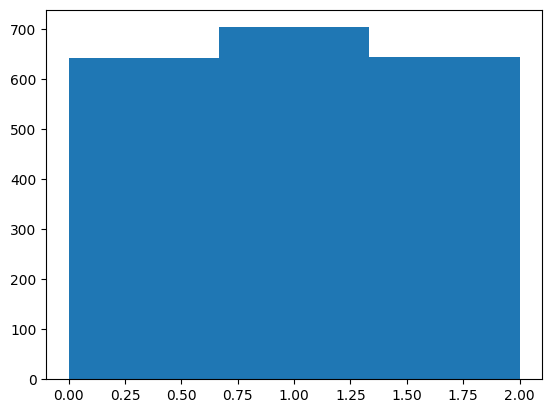

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
y_pred = list()
y_true = list()
for t in tqdm(test):
    d = t[0].to(device)
    out = model(d,t[1])
    y_true.append(torch.argmax(d.y))
    y_pred.append(torch.argmax(out))
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

[tensor(2), tensor(2), tensor(0), tensor(1), tensor(1), tensor(2), tensor(1), tensor(2), tensor(2), tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(2), tensor(0), tensor(1), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(2), tensor(2), tensor(1), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(1), tensor(0), tensor(0), tensor(2), tensor(1), tensor(0), tensor(0), tensor(0), tensor(2), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(2), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(2), tensor(1), tensor(1), tensor(1), tensor(2), tensor(1), tensor(2), tensor(1), tensor(1), tensor(2), tensor(0), tensor(2), tensor(1), tensor(1), tensor(0), tensor(2), tensor(1), tensor(2), tensor(1), tensor(1), tensor(2), tensor(1), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2)

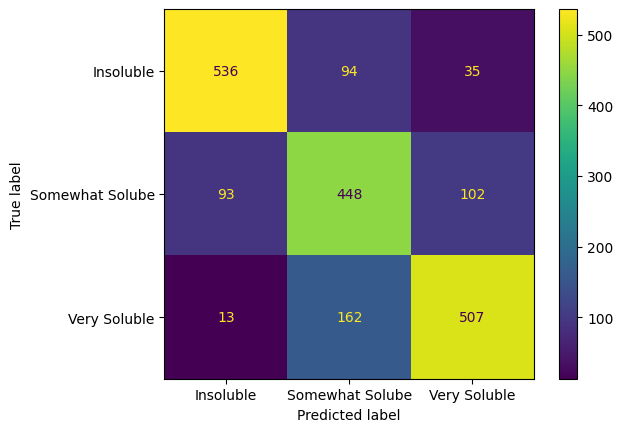

In [ ]:
import sklearn
from sklearn import metrics
print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Insoluble", "Somewhat Solube", "Very Soluble"])

import matplotlib.pyplot as plt

cm_display.plot()
plt.show()




